# Titanic 

The following analysis is bases on the work of mrdbourke https://github.com/mrdbourke/your-first-kaggle-submission

## The Goal and overview

## The Goal
The goal of this project is simple: use machine learning to create a model that predicts which passengers survived the Titanic shipwreck. 

Why it can be useful: Although this projcet is made in order to practice the basics of ML, the model that I will develop can be used in numerous ways. One potential use is to create a similar model in order to predict which patients that come to ER will require hospitalization in ICU in 72 hours after admission. 

## The metric
The score is the percentage of passengers correctly predicted.

# Importing libraries

In [1]:
import sys
assert sys.version_info >= (3, 5)
import sklearn
assert sklearn.__version__ >= "0.20"

# Start Python Imports
import math, time, random, datetime

import os
# Import Dependencies
%matplotlib inline
import matplotlib as mpl
import matplotlib.pyplot as plt
mpl.rc('axes', labelsize=14)
mpl.rc('xtick', labelsize=12)
mpl.rc('ytick', labelsize=12)

# Start Python Imports
import math, time, random, datetime

# Preprocessing
from sklearn.preprocessing import OneHotEncoder, LabelEncoder, label_binarize

# Data Manipulation
import numpy as np
import pandas as pd
from sklearn.preprocessing import OneHotEncoder
from sklearn.compose import ColumnTransformer

# Visualization 
import matplotlib.pyplot as plt
import missingno
import seaborn as sns
plt.style.use('seaborn-whitegrid')


np.random.seed(42)

# Importing the training data

In [2]:
train_dataset = pd.read_csv("train.csv")

# Data Descriptions

Survival: 0 = No, 1 = Yes

pclass (Ticket class): 1 = 1st, 2 = 2nd, 3 = 3rd

sex: Sex

Age: Age in years

sibsp: number of siblings/spouses aboard the Titanic

parch: number of parents/children aboard the Titanic

ticket: Ticket number

fare: Passenger fare

cabin: Cabin number

embarked: Port of Embarkation, C = Cherbourg, Q = Queenstown, S = Southampton

## EDA

In [3]:
train_dataset.head()

,PassengerId,Survived,Pclass,Name,Sex,Age,SibSp,Parch,Ticket,Fare,Cabin,Embarked
0,1,0,3,"Braund, Mr. Owen Harris",male,22.0,1,0,A/5 21171,7.2500,NaN,S
1,2,1,1,"Cumings, Mrs. John Bradley (Florence Briggs Th...",female,38.0,1,0,PC 17599,71.2833,C85,C
2,3,1,3,"Heikkinen, Miss. Laina",female,26.0,0,0,STON/O2. 3101282,7.9250,NaN,S
3,4,1,1,"Futrelle, Mrs. Jacques Heath (Lily May Peel)",female,35.0,1,0,113803,53.1000,C123,S
4,5,0,3,"Allen, Mr. William Henry",male,35.0,0,0,373450,8.0500,NaN,S


In [4]:
train_dataset.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 891 entries, 0 to 890
Data columns (total 12 columns):
PassengerId    891 non-null int64
Survived       891 non-null int64
Pclass         891 non-null int64
Name           891 non-null object
Sex            891 non-null object
Age            714 non-null float64
SibSp          891 non-null int64
Parch          891 non-null int64
Ticket         891 non-null object
Fare           891 non-null float64
Cabin          204 non-null object
Embarked       889 non-null object
dtypes: float64(2), int64(5), object(5)
memory usage: 83.7+ KB


In [5]:
train_dataset["Sex"].value_counts()

male      577
female    314
Name: Sex, dtype: int64

In [6]:
train_dataset["Survived"].value_counts()

0    549
1    342
Name: Survived, dtype: int64

In [7]:
train_dataset["Embarked"].value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

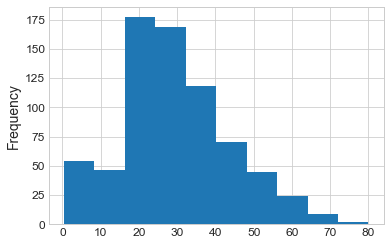

In [8]:
train_dataset.Age.plot.hist()

## New Dataframes
In order to distinguish between different datatypes I will create two new dataframes

In [9]:
discretised_data = pd.DataFrame() # for discretised continuous variables
continous_data = pd.DataFrame() # for continuous variables

# Exploring features

In order to better understand the data, lets explore variables one by one

## Survived

This is the most important variable - it is going to be the variable that we want to predict

0    549
1    342
Name: Survived, dtype: int64


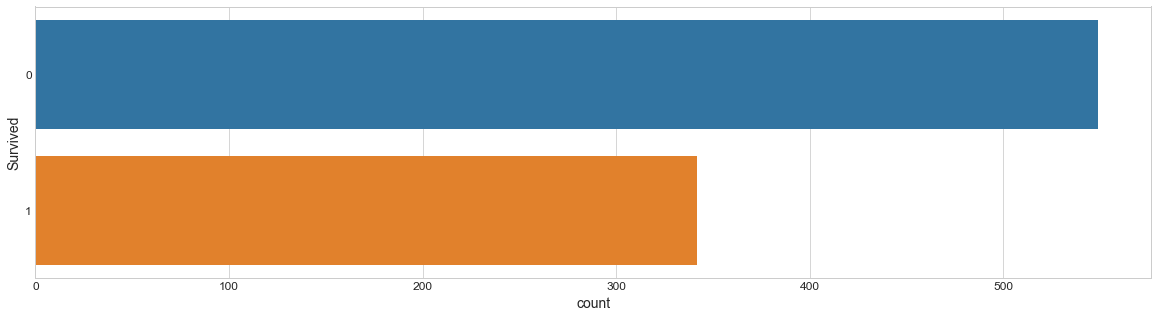

In [10]:
#How many people have survived?

fig = plt.figure(figsize=(20,5))
sns.countplot(y='Survived', data=train_dataset);
print(train_dataset['Survived'].value_counts())

In [11]:
discretised_data['Survived'] = train_dataset['Survived']
continous_data['Survived'] = train_dataset['Survived']

## Feature: Pclass

Description: The ticket class of the passenger.

Key: 1 = 1st, 2 = 2nd, 3 = 3rd
    
### Distribution

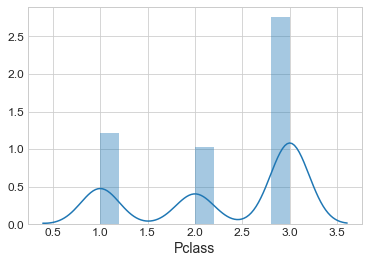

In [12]:
sns.distplot(train_dataset["Pclass"])

In [13]:
# How many values are missing?

train_dataset["Pclass"].isnull().sum()

0

In [14]:
discretised_data['Pclass'] = train_dataset['Pclass']
continous_data['Pclass'] = train_dataset['Pclass']

### Feature: Name

Although we could extract some information based on the name (for example extract Mr., Miss etc) we won't due that because we want to keep this EDA fast

#### Feature: Sex

Description: The sex of the passenger (male or female).

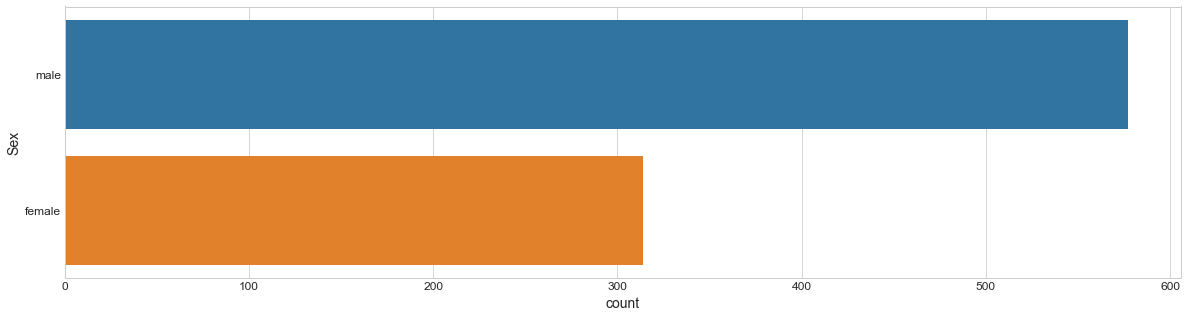

In [15]:
# Let's view the distribution of Sex
plt.figure(figsize=(20, 5))
sns.countplot(y="Sex", data=train_dataset);

In [16]:
train_dataset["Sex"].isnull().sum()

0

In [17]:
discretised_data['Sex'] = train_dataset['Sex']
discretised_data['Sex'] = np.where(discretised_data['Sex']=='female', 1, 0)

continous_data["Sex"] = train_dataset["Sex"]

### Feature: Age

Description: The age of the passenger.

In [18]:
# How many missing values are there?

train_dataset["Age"].isnull().sum()

177

##### Function to create cont and distribution visualisations

In [19]:
def plot_count_dist(data, bin_df, label_column, target_column, figsize=(20, 5), use_bin_df=False):
    """
    Function to plot counts and distributions of a label variable and 
    target variable side by side.
    ::param_data:: = target dataframe
    ::param_bin_df:: = binned dataframe for countplot
    ::param_label_column:: = binary labelled column
    ::param_target_column:: = column you want to view counts and distributions
    ::param_figsize:: = size of figure (width, height)
    ::param_use_bin_df:: = whether or not to use the bin_df, default False
    """
    if use_bin_df: 
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=bin_df);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});
    else:
        fig = plt.figure(figsize=figsize)
        plt.subplot(1, 2, 1)
        sns.countplot(y=target_column, data=data);
        plt.subplot(1, 2, 2)
        sns.distplot(data.loc[data[label_column] == 1][target_column], 
                     kde_kws={"label": "Survived"});
        sns.distplot(data.loc[data[label_column] == 0][target_column], 
                     kde_kws={"label": "Did not survive"});

### Feature Sibsp

Description: The number of siblings/spouses the passenger has aboard the Titanic.

In [20]:
#How many siblings/spouses the passanger has aboard the Titanic?

train_dataset.SibSp.isnull().sum()

0

In [21]:
train_dataset.SibSp.value_counts()

0    608
1    209
2     28
4     18
3     16
8      7
5      5
Name: SibSp, dtype: int64

In [22]:
discretised_data['SibSp'] = train_dataset['SibSp']
continous_data['SibSp'] = train_dataset['SibSp']

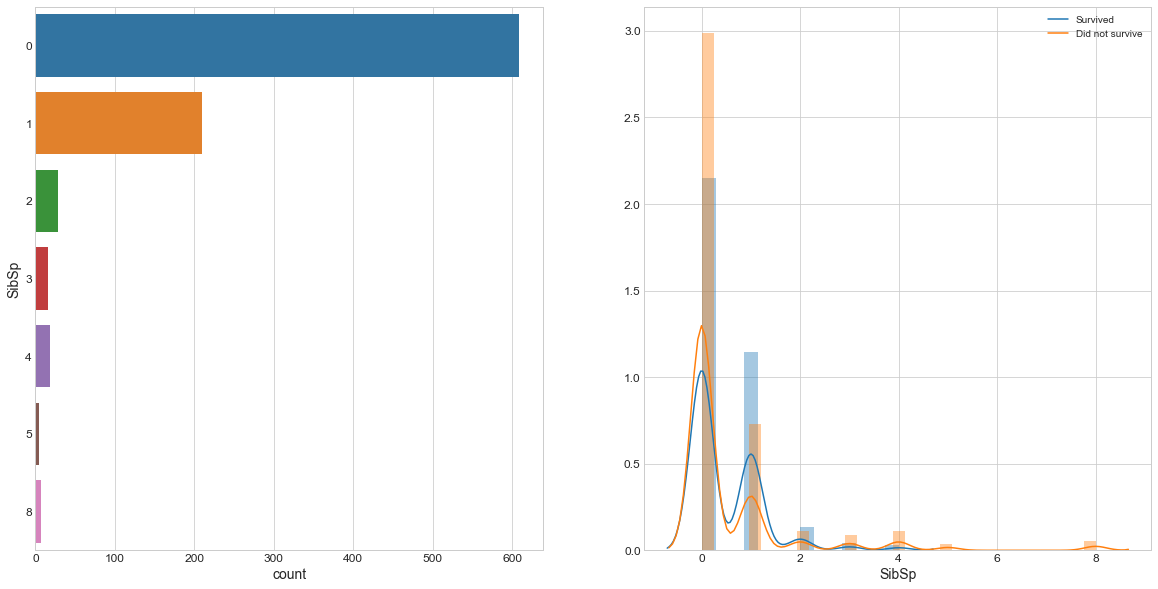

In [23]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train_dataset, 
                bin_df=discretised_data, 
                label_column='Survived', 
                target_column='SibSp', 
                figsize=(20, 10))

### Feature: Parch

Description: The number of parents/children the passenger has aboard the Titanic.

In [24]:
#How many parents/children the passanger has aboard the Titanic?

train_dataset.Parch.isnull().sum()

0

In [25]:
train_dataset.Parch.value_counts()

0    678
1    118
2     80
5      5
3      5
4      4
6      1
Name: Parch, dtype: int64

In [26]:
discretised_data['Parch'] = train_dataset['Parch']
continous_data['Parch'] = train_dataset['Parch']

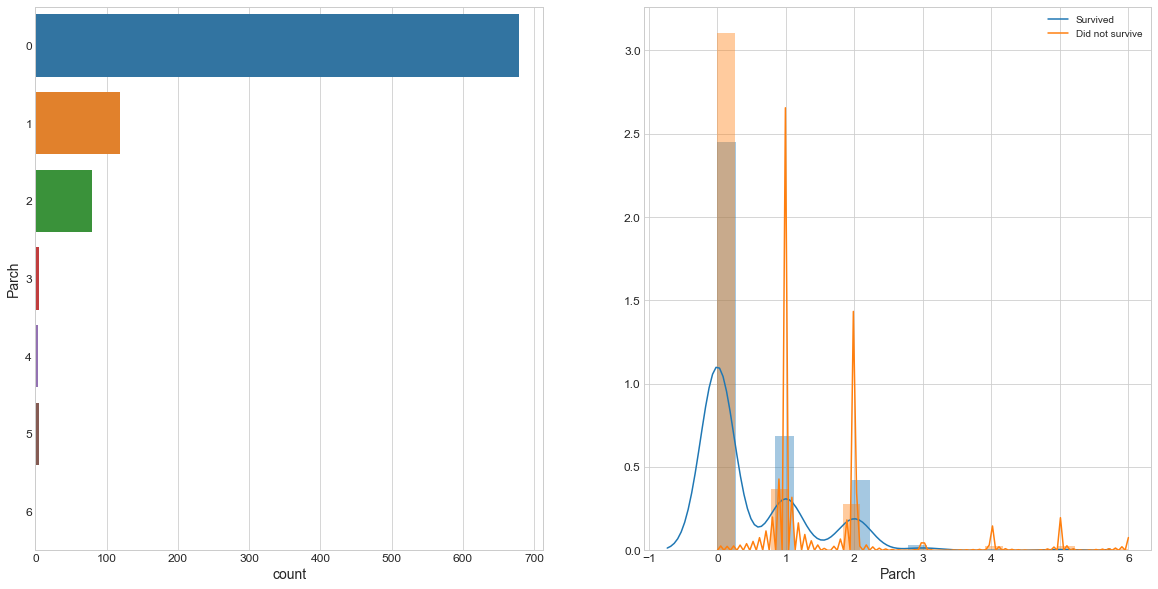

In [27]:
# Visualise the counts of SibSp and the distribution of the values
# against Survived
plot_count_dist(train_dataset, 
                bin_df=discretised_data, 
                label_column='Survived', 
                target_column='Parch', 
                figsize=(20, 10))

### Feature: Ticket

Description: The ticket number of the boarding passenger.

In [28]:
# How many kinds of ticket are there?
train_dataset.Ticket.value_counts()

347082      7
CA. 2343    7
1601        7
347088      6
CA 2144     6
           ..
343275      1
218629      1
347068      1
17464       1
349236      1
Name: Ticket, Length: 681, dtype: int64

In [29]:
# How many unique kinds of Tickets are there?

print("There are {} unique Ticket values.".format(len(train_dataset.Ticket.unique())))

There are 681 unique Ticket values.


Due to the large number of unique values of tickets we won't use this feature for now

### Feature: Fare

Description: How much the ticket cost.

In [30]:
train_dataset.Fare.isnull().sum()

0

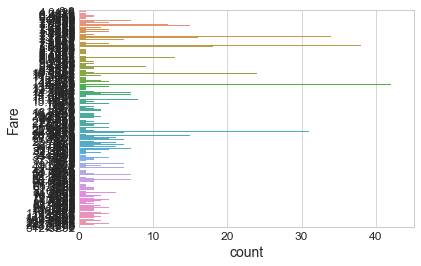

In [31]:
# How many diffrent values of Fare are there?

sns.countplot(y="Fare", data=train_dataset)

In [32]:
# How many unique kinds of Fare are there?

print("There are {} unique Fare values.".format(len(train_dataset.Fare.unique())))

There are 248 unique Fare values.


In [33]:
#Add fare to sub dataframes

discretised_data['Fare'] = pd.cut(train_dataset['Fare'], bins=5)
continous_data['Fare'] = train_dataset['Fare']

In [34]:
continous_data.Fare.value_counts()

8.0500     43
13.0000    42
7.8958     38
7.7500     34
26.0000    31
           ..
8.4583      1
9.8375      1
8.3625      1
14.1083     1
17.4000     1
Name: Fare, Length: 248, dtype: int64

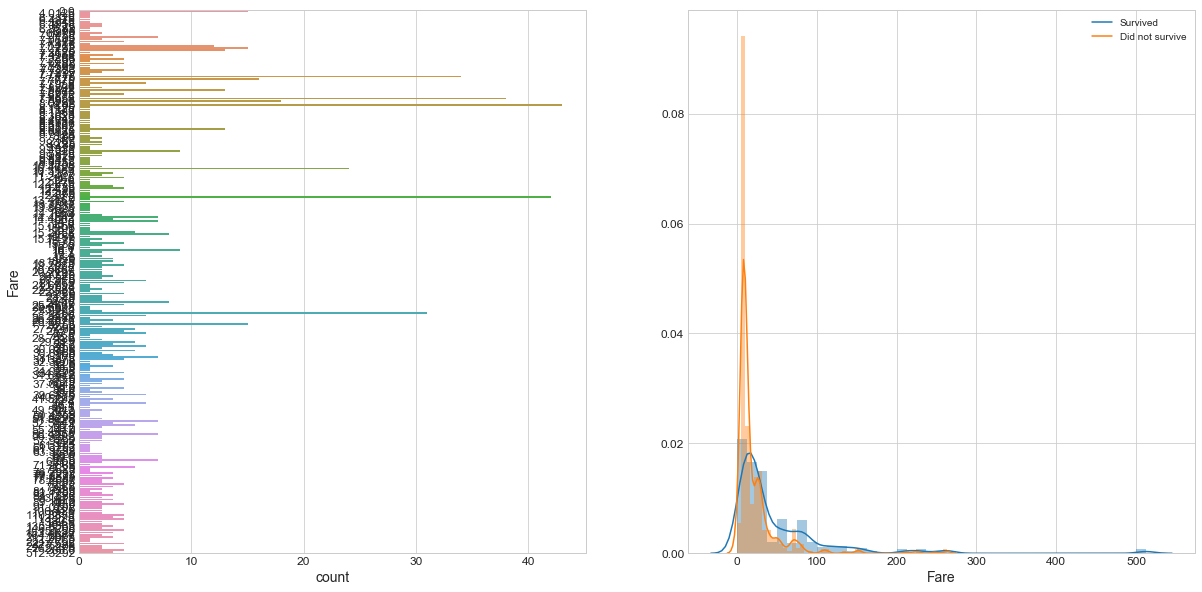

In [35]:
# Visualise the Fare bins and the distribution of the values
# against Survived
plot_count_dist(train_dataset, 
                bin_df=continous_data, 
                label_column='Survived', 
                target_column='Fare', 
                figsize=(20, 10),
                use_bin_df=True)

### Feature: Embarked

Description: The port where the passenger boarded the Titanic.

Key: C = Cherbourg, Q = Queenstown, S = Southampton

In [36]:
train_dataset.Embarked.isnull().sum()

2

In [37]:
# What kind of values are in Embarked?
train_dataset.Embarked.value_counts()

S    644
C    168
Q     77
Name: Embarked, dtype: int64

We will deal with the missing values of "Embarked" by removing the rows that have missing values

In [38]:
discretised_data['Embarked'] = train_dataset['Embarked']
continous_data['Embarked'] = train_dataset['Embarked']

In [39]:
# Remove Embarked
print(len(discretised_data))
discretised_data = discretised_data.dropna(subset=['Embarked'])
continous_data = continous_data.dropna(subset=['Embarked'])
print(len(discretised_data))

891
889


## Feature Encoding

Now we have our two sub dataframes ready. We can encode the features so they're ready to be used with our machine learning models.

We will encode our binned dataframe (df_bin) with one-hot encoding and our continuous dataframe (df_con) with the label encoding function from sklearn.

In [40]:
discretised_data.head()

,Survived,Pclass,Sex,SibSp,Parch,Fare,Embarked
0,0,3,0,1,0,"(-0.512, 102.466]",S
1,1,1,1,1,0,"(-0.512, 102.466]",C
2,1,3,1,0,0,"(-0.512, 102.466]",S
3,1,1,1,1,0,"(-0.512, 102.466]",S
4,0,3,0,0,0,"(-0.512, 102.466]",S
